In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1) Create Image_File DataFrame

In [8]:
dir_ = Path('/content/drive/MyDrive/Colab Notebooks/datasets/2nd_snack')
filepaths = list(dir_.glob(r'**/*.jpg'))

def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head()

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/dataset...,banana
1,/content/drive/MyDrive/Colab Notebooks/dataset...,pizza
2,/content/drive/MyDrive/Colab Notebooks/dataset...,pizza
3,/content/drive/MyDrive/Colab Notebooks/dataset...,pepero
4,/content/drive/MyDrive/Colab Notebooks/dataset...,pie


##2) Data EDA

In [9]:
print('The number of pictures:', df.shape[0])
print('The number of snacks:', len(df.Label.unique()))
print('Labels:', df.Label.unique())

The number of pictures: 2500
The number of snacks: 10
Labels: ['banana' 'pizza' 'pepero' 'pie' 'heim' 'chip' 'turtle' 'shrimp' 'onion'
 'oreo']


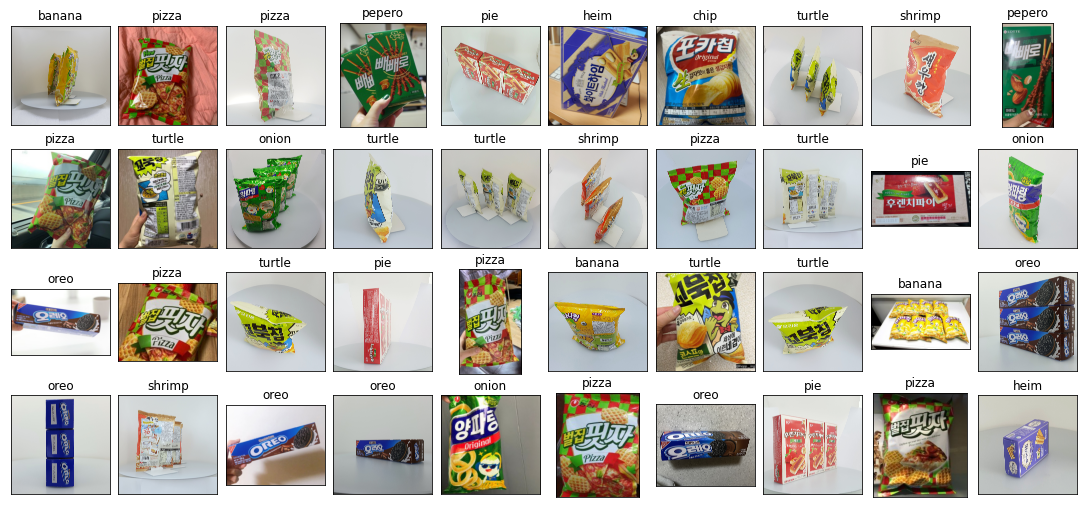

In [10]:
# 데이터 확인
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

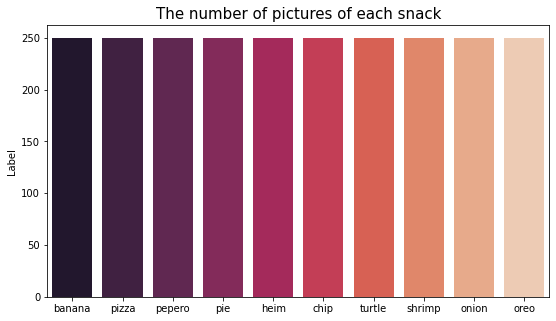

In [11]:
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("The number of pictures of each snack", fontsize = 15)
plt.show()

##3) Train / Test Split

In [12]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0)
train_df.shape,test_df.shape

((2250, 2), (250, 2))

In [13]:
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=0)
train_df.shape, valid_df.shape

((2025, 2), (225, 2))

4) ImageDataGenerator( ) & flow_from_dataframe( )

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.)
valid_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='Filepath',
                                                    y_col='Label',
                                                    target_size=(75, 75),
                                                    batch_size=16,
                                                    class_mode='categorical'
                                                    )

valid_generator  = valid_datagen.flow_from_dataframe(valid_df,
                                                     x_col='Filepath',
                                                     y_col='Label',
                                                     target_size=(75, 75),
                                                     batch_size=16,
                                                     class_mode='categorical'
                                                     )

Found 2025 validated image filenames belonging to 10 classes.
Found 225 validated image filenames belonging to 10 classes.


##5) Test train_generator

In [15]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (16, 75, 75, 3)
배치 레이블 크기: (16, 10)


In [16]:
labels_batch

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

##6) Data Augmentation

In [17]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(75, 75), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=10,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(75, 75),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=16,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(75, 75),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=16,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

##7) 전이학습 모델 적용

In [18]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(75, 75, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    # 라벨 개수가 10개이기 때문에 Dencs도 10으로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 1823 validated image filenames belonging to 10 classes.
Found 202 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.


29084464/29084464 [==============================] - 2s 0us/step


DenseNet121          trained in 1230.19 sec
9406464/9406464 [==============================] - 0s 0us/step
MobileNetV2          trained in 131.34 sec
74836368/74836368 [==============================] - 4s 0us/step
DenseNet201          trained in 143.29 sec
16705208/16705208 [==============================] - 2s 0us/step
EfficientNetB0       trained in 134.75 sec
27018416/27018416 [==============================] - 2s 0us/step
EfficientNetB1       trained in 135.34 sec
87910968/87910968 [==============================] - 5s 0us/step


InceptionV3          trained in 132.01 sec
12683000/12683000 [==============================] - 2s 0us/step
MobileNetV3Large     trained in 130.14 sec
234545216/234545216 [==============================] - 11s 0us/step
ResNet152V2          trained in 138.66 sec
94765736/94765736 [==============================] - 5s 0us/step
ResNet50             trained in 128.39 sec
94668760/94668760 [==============================] - 5s 0us/step
ResNet50V2           trained in 127.52 sec
80134624/80134624 [==============================] - 4s 0us/step
VGG19                trained in 125.23 sec
58889256/58889256 [==============================] - 3s 0us/step
VGG16                trained in 122.13 sec
83683744/83683744 [==============================] - 4s 0us/step
Xception             trained in 125.05 sec


In [19]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

16/16 [==============================] - 150s 10s/step
**DenseNet121 has a 88.00% accuracy on the test set**
16/16 [==============================] - 17s 995ms/step
**MobileNetV2 has a 92.00% accuracy on the test set**
16/16 [==============================] - 19s 996ms/step
**DenseNet201 has a 94.00% accuracy on the test set**
16/16 [==============================] - 18s 1s/step
**EfficientNetB0 has a 6.00% accuracy on the test set**
16/16 [==============================] - 18s 1s/step
**EfficientNetB1 has a 10.00% accuracy on the test set**
16/16 [==============================] - 17s 992ms/step
**InceptionV3 has a 64.80% accuracy on the test set**
16/16 [==============================] - 17s 997ms/step
**MobileNetV3Large has a 16.80% accuracy on the test set**
16/16 [==============================] - 18s 996ms/step
**ResNet152V2 has a 68.40% accuracy on the test set**
16/16 [==============================] - 17s 987ms/step
**ResNet50 has a 24.40% accuracy on the test set**
16/16 [===

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9010,0.940,143.29
1,MobileNetV2,0.8861,0.920,131.34
2,DenseNet121,0.8713,0.880,1230.19
3,VGG19,0.7030,0.764,125.23
4,Xception,0.7129,0.748,125.05
5,VGG16,0.6733,0.712,122.13
6,ResNet50V2,0.6832,0.692,127.52
7,ResNet152V2,0.6733,0.684,138.66
8,InceptionV3,0.6337,0.648,132.01
9,ResNet50,0.2376,0.244,128.39


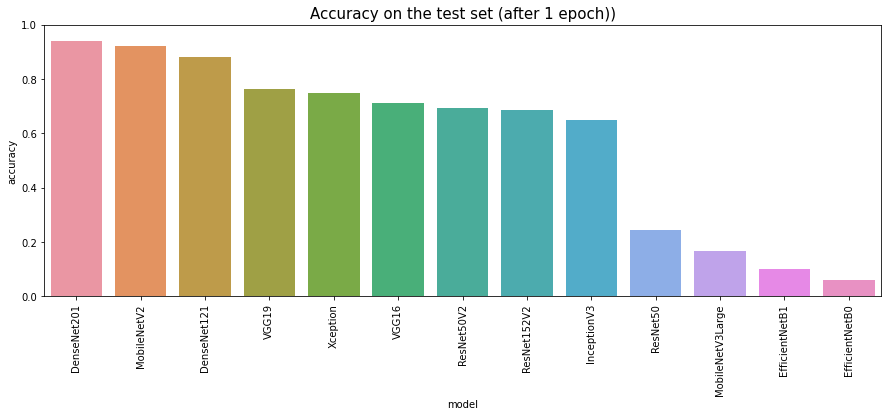

In [20]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

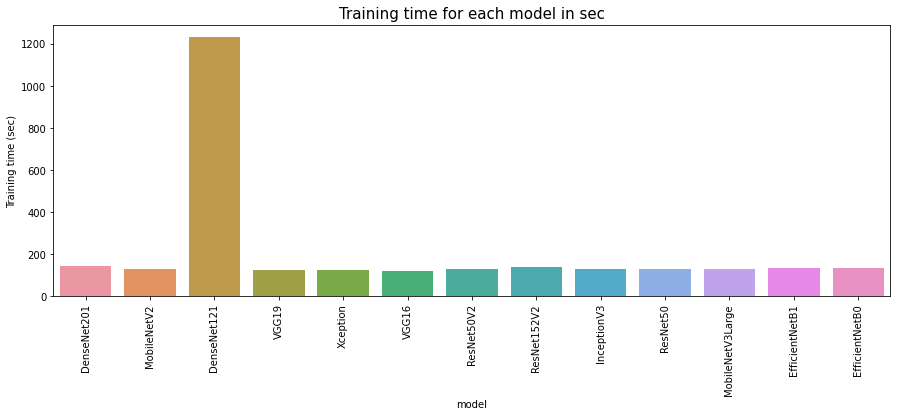

In [21]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

- epoch1 에서 타 학습모델 대비 성능이 좋고 학습속도가 평균적인 DenceNet201을 선택, 추가학습을 시킨다.

In [22]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201)
history = model.fit(train_images,validation_data=val_images,epochs=10)

Found 2025 validated image filenames belonging to 10 classes.
Found 225 validated image filenames belonging to 10 classes.
Found 250 validated image filenames belonging to 10 classes.
Epoch 1/10
203/203 [==============================] - 283s 1s/step - loss: 0.5875 - accuracy: 0.8143 - val_loss: 0.1241 - val_accuracy: 0.9600
Epoch 2/10
203/203 [==============================] - 139s 684ms/step - loss: 0.0696 - accuracy: 0.9802 - val_loss: 0.1872 - val_accuracy: 0.9378
Epoch 3/10
203/203 [==============================] - 139s 684ms/step - loss: 0.0508 - accuracy: 0.9862 - val_loss: 0.1487 - val_accuracy: 0.9422
Epoch 4/10
203/203 [==============================] - 139s 686ms/step - loss: 0.0420 - accuracy: 0.9872 - val_loss: 0.0898 - val_accuracy: 0.9644
Epoch 5/10
203/203 [==============================] - 139s 686ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.0418 - val_accuracy: 0.9822
Epoch 6/10
203/203 [==============================] - 138s 677ms/step - loss: 0.0419 - ac

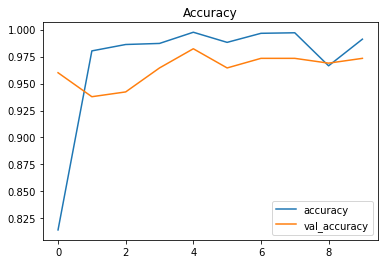

In [23]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

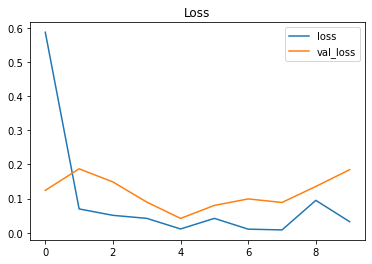

In [24]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
    
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

16/16 [==============================] - 20s 1s/step
Accuracy on the test set: 98.40%


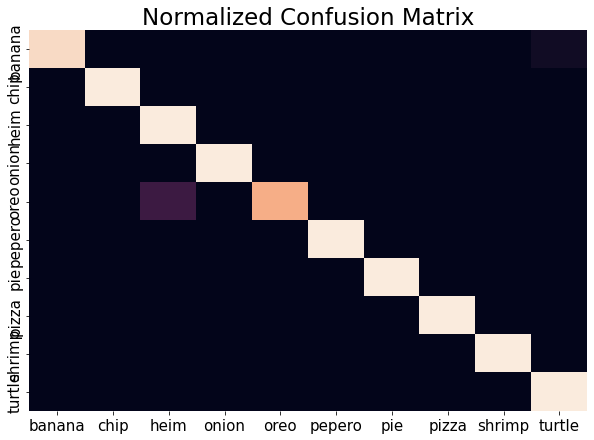

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

##8) Model Evaluate

In [27]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  x_col='Filepath',
                                                  y_col='Label',
                                                  target_size=(75, 75),
                                                  batch_size=16)

Found 250 validated image filenames belonging to 10 classes.


In [28]:
loss, accuracy = model.evaluate(test_generator)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

16/16 [==============================] - 18s 1s/step - loss: 0.2286 - accuracy: 0.9400
Loss = 0.22859
Accuracy = 0.94000


##9) Model Saving

In [29]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
model.save('/content/drive/My Drive/Colab Notebooks/models/data3_DenceNet201_tuningX_jwson.h5')

In [31]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 76589
-rw------- 1 root root 78426672 Nov 24 05:04 data3_DenceNet201_tuningX_jwson.h5


##10) Model Load

In [32]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
from tensorflow.keras.models import load_model

model_1 = load_model('/content/drive/My Drive/Colab Notebooks/models/data3_DenceNet201_tuningX_jwson.h5')